In [46]:
%matplotlib tk

**Final Project**

**Part 1: Data Cleaning/Clustering**

For this section, we provide the data set MAS202M_2025_synthetic_data_20250313.csv, which is a synthetic data set.

1. Prepare the provided data set (or another data set of your choice) for further analysis. Using the tools at your disposal for data cleaning, prepare the data set to maximize the expected performance of a clustering algorithm trained on the data set. Note the steps taken regardless of whether or not they result in modifications to the data set. 
    
2. Build a model to cluster the data set. Describe the resulting classifier and its performance, i.e., how it clusters the data. 

In [24]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots, cm, savefig
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import (ttest_1samp,
                         ttest_rel,
                         ttest_ind,
                         t as t_dbn)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests as mult_test
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss,
                             RocCurveDisplay)
from sklearn.ensemble import \
                             (RandomForestRegressor as RF,
                             GradientBoostingRegressor as GBR)
from ISLP.bart import BART
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import \
                             (KMeans,
                             AgglomerativeClustering)
from scipy.cluster.hierarchy import \
                             (dendrogram,
                             cut_tree)
from ISLP.cluster import compute_linkage
import warnings; warnings.simplefilter('ignore')
import os
import sys
np.random.seed(42)

In [25]:
# Read csv data to a DataFrame and show first 5 rows
df1 = pd.read_csv('MAS202M_2025_synthetic_data_20250313.csv')
df1.head()

,index,id,col1,col2,col3,col4,col5,col6
0,0,sample74,1.027864,-13.736045,113.574665,-15.994390,0.001800,113.574665
1,1,sample860,0.779651,-10.757211,97.170570,-20.520187,0.217476,97.170570
2,2,sample1631,0.084184,2.152533,130.908017,5.077833,0.486460,130.908017
3,3,sample1536,-0.921573,-5.068522,143.986243,45.164685,0.277102,143.986243
4,4,sample1652,-0.849712,0.011196,78.315258,44.647674,0.930156,78.315258


In [26]:
# Show shape
df1.shape

(1790, 8)

In [27]:
# Check for duplicate values
np.sum(df1.duplicated(subset=['id','col1','col2','col3','col4','col5','col6']))

96

We have 96 duplicate observations 

In [28]:
# Drop all duplicated rows
df1 = df1.drop_duplicates(subset=['id','col1','col2','col3','col4','col5','col6'])
df1.shape

(1694, 8)

In [29]:
# Check for similarity between col3 and col6
np.sum(df1.iloc[:,-1] == df1.iloc[:,4])

1677

In [30]:
# Check percentage similarity
print(100*np.sum(df1.iloc[:,-1] == df1.iloc[:,4])/df1.shape[0])

98.99645808736717


In [31]:
# Check for missing values in dataset
print('Missing values from id col:',np.sum(pd.isna(df1.iloc[:,1])))
print('Missing values from col1:',np.sum(pd.isna(df1.iloc[:,2])))
print('Missing values from col2:',np.sum(pd.isna(df1.iloc[:,3])))
print('Missing values from col3:',np.sum(pd.isna(df1.iloc[:,4])))
print('Missing values from col4:',np.sum(pd.isna(df1.iloc[:,5])))
print('Missing values from col5',np.sum(pd.isna(df1.iloc[:,6])))
print('Missing values from col6',np.sum(pd.isna(df1.iloc[:,7])))

Missing values from id col: 11
Missing values from col1: 4
Missing values from col2: 9
Missing values from col3: 9
Missing values from col4: 5
Missing values from col5 4
Missing values from col6 8


In [32]:
# Create a single vector that is a union of col3 and col6
s = df1.iloc[:,4]
d = df1.iloc[:,-1]
while (np.sum(pd.isna(d)) != 0):
    x = np.argmax(pd.isna(d))
    d.iloc[x] = s.iloc[x]

In [33]:
# Create a new column that is a union of col3 and col6
df1['col_3u6'] = d

In [34]:
# Verify that there are no missing values in col_3u6
np.sum(pd.isna(df1.iloc[:,-1]))

0

We still have some duplicates and we know that column 3 and column 6 share around $99\%$ values. 

In [35]:
# Drop redundant columns
df = df1.drop(['col3','col6'], axis=1)

In [36]:
# Show first 5 rows
df.head()

,index,id,col1,col2,col4,col5,col_3u6
0,0,sample74,1.027864,-13.736045,-15.994390,0.001800,113.574665
1,1,sample860,0.779651,-10.757211,-20.520187,0.217476,97.170570
2,2,sample1631,0.084184,2.152533,5.077833,0.486460,130.908017
3,3,sample1536,-0.921573,-5.068522,45.164685,0.277102,143.986243
4,4,sample1652,-0.849712,0.011196,44.647674,0.930156,78.315258


In [37]:
# Check for missing values after modification
print('Missing values from id col:',np.sum(pd.isna(df.iloc[:,1])))
print('Missing values from col1:',np.sum(pd.isna(df.iloc[:,2])))
print('Missing values from col2:',np.sum(pd.isna(df.iloc[:,3])))
print('Missing values from col4:',np.sum(pd.isna(df.iloc[:,4])))
print('Missing values from col5:',np.sum(pd.isna(df.iloc[:,5])))
print('Missing values from col_3u6:',np.sum(pd.isna(df.iloc[:,6])))

Missing values from id col: 11
Missing values from col1: 4
Missing values from col2: 9
Missing values from col4: 5
Missing values from col5: 4
Missing values from col_3u6: 0


We have around 50 missing values in the data set or around $0.5\%$ of the data is missing, which is acceptable.

In [38]:
# Check for duplicated values after modification
print('Duplicated values from id col:',np.sum(df.duplicated(subset=['id'])))
print('Duplicated values from col1:',np.sum(df.duplicated(subset=['col1'])))
print('Duplicated values from col2:',np.sum(df.duplicated(subset=['col2'])))
print('Duplicated values from col4:',np.sum(df.duplicated(subset=['col4'])))
print('Duplicated values from col5:',np.sum(df.duplicated(subset=['col5'])))
print('Duplicated values from col_3u6:',np.sum(df.duplicated(subset=['col_3u6'])))

Duplicated values from id col: 14
Duplicated values from col1: 7
Duplicated values from col2: 11
Duplicated values from col4: 7
Duplicated values from col5: 7
Duplicated values from col_3u6: 4


In [39]:
# Remove all duplicated samples in id column
s = []
for i in range(np.sum(df.duplicated(subset=['id']))):
    x = np.argmax(df.duplicated(subset=['id']))
    t = df.index
    try:
        if np.isnan(df.iloc[x,1]):
            df = df.drop(t[x])
    except:
        df = df.drop(t[x])
print(np.sum(pd.isna(df.iloc[:,1])))
print(df.shape)

1
(1680, 7)


In [40]:
# Check if there are missing value in id column, then drop that row
t = df.index
x = np.argmax(pd.isna(df.iloc[:,1]))
df = df.drop(t[x])
print(df.shape)

(1679, 7)


In [41]:
# Check for missing values after modification of id column
print('Missing values from id col:',np.sum(pd.isna(df.iloc[:,1])))
print('Missing values from col1:',np.sum(pd.isna(df.iloc[:,2])))
print('Missing values from col2:',np.sum(pd.isna(df.iloc[:,3])))
print('Missing values from col4:',np.sum(pd.isna(df.iloc[:,4])))
print('Missing values from col5:',np.sum(pd.isna(df.iloc[:,5])))
print('Missing values from col_new:',np.sum(pd.isna(df.iloc[:,6])))

Missing values from id col: 0
Missing values from col1: 4
Missing values from col2: 9
Missing values from col4: 4
Missing values from col5: 4
Missing values from col_new: 0


In [42]:
# Fill rest of missing values with median of column
df_filled = df.fillna(df.median(numeric_only=True))

# Verify that there are no more missing values
print('Missing values from id col:',np.sum(pd.isna(df_filled.iloc[:,1])))
print('Missing values from col1:',np.sum(pd.isna(df_filled.iloc[:,2])))
print('Missing values from col2:',np.sum(pd.isna(df_filled.iloc[:,3])))
print('Missing values from col4:',np.sum(pd.isna(df_filled.iloc[:,4])))
print('Missing values from col5:',np.sum(pd.isna(df_filled.iloc[:,5])))
print('Missing values from col_3u6:',np.sum(pd.isna(df_filled.iloc[:,6])))

Missing values from id col: 0
Missing values from col1: 0
Missing values from col2: 0
Missing values from col4: 0
Missing values from col5: 0
Missing values from col_3u6: 0


____________________________________________________________________________________________________________________________________________________________________

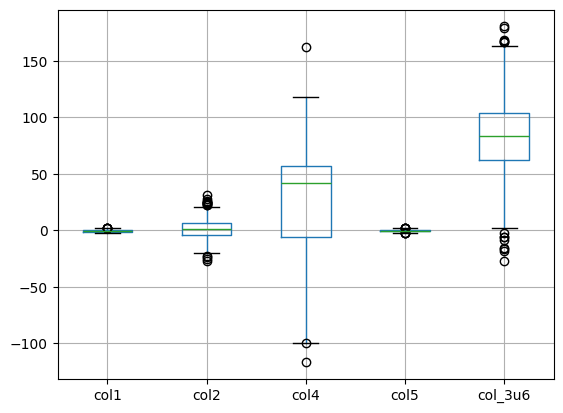

In [46]:
# Check the distribution and more via boxplot of modified data
feature_names = df_filled.drop(['index','id'],axis=1).columns
df_filled.boxplot(column=['col1','col2','col4','col5','col_3u6'])
savefig('figure/boxpl.pdf')
plt.show()

On the boxplot we can very different distributions between the variables. col4 shows a skewed distribution and all of the variables have some outliers. Before we use a clustering algorithm we need to scale the data first.

We use StandardScaler to scale our features so that the distributions properly align with each other. Then we can use PCA to choose K in k-means clustering, and reduce dimension.

We use PVE plots to determine the number of PC for our clustering algorithm.

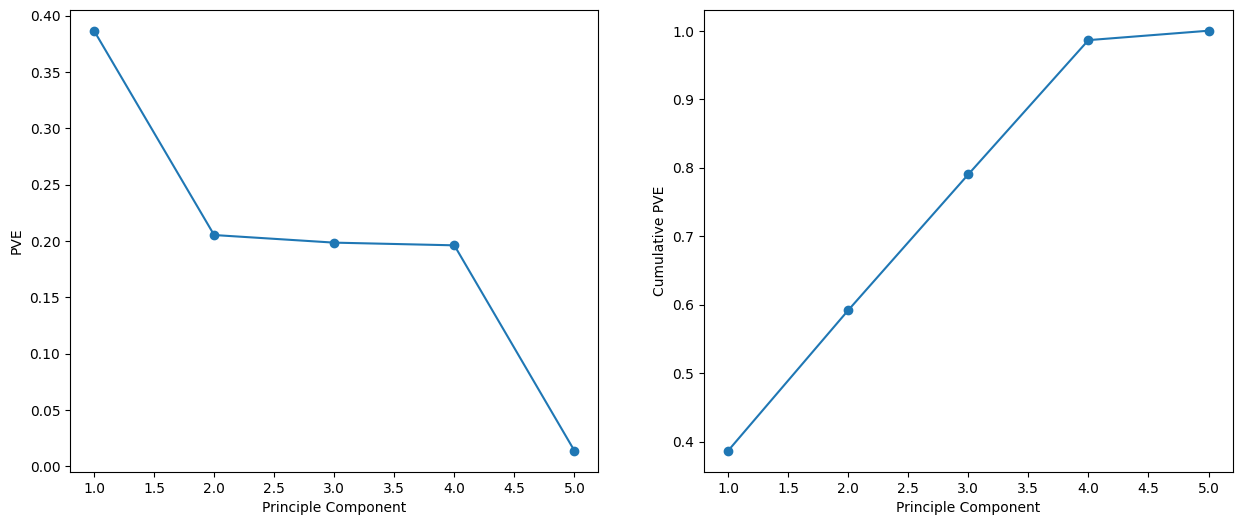

In [47]:
# Use only numerical columns for scaling, and unsupervised learning
df_clus = df_filled.drop(['index','id'],axis=1)
ss = StandardScaler()
df_scaled = ss.fit_transform(df_clus)

# Apply PCA to our scaled data
pca = PCA()
pca.fit(df_scaled)
scores = pca.transform(df_scaled)

ticks = np.arange(pca.n_components_)+1

# Plot PVE and cumulative PVE to determine how many components we can drop
fig, ax = subplots(1,2,figsize=(15,6))
ax[0].plot(ticks,
            pca.explained_variance_ratio_,
            marker='o')
ax[0].set_ylabel('PVE')
ax[0].set_xlabel('Principle Component')
ax[1].plot(ticks,
          pca.explained_variance_ratio_.cumsum(),
          marker='o')
ax[1].set_ylabel('Cumulative PVE')
ax[1].set_xlabel('Principle Component')
fig.savefig('figure/PVE.pdf')
plt.show()

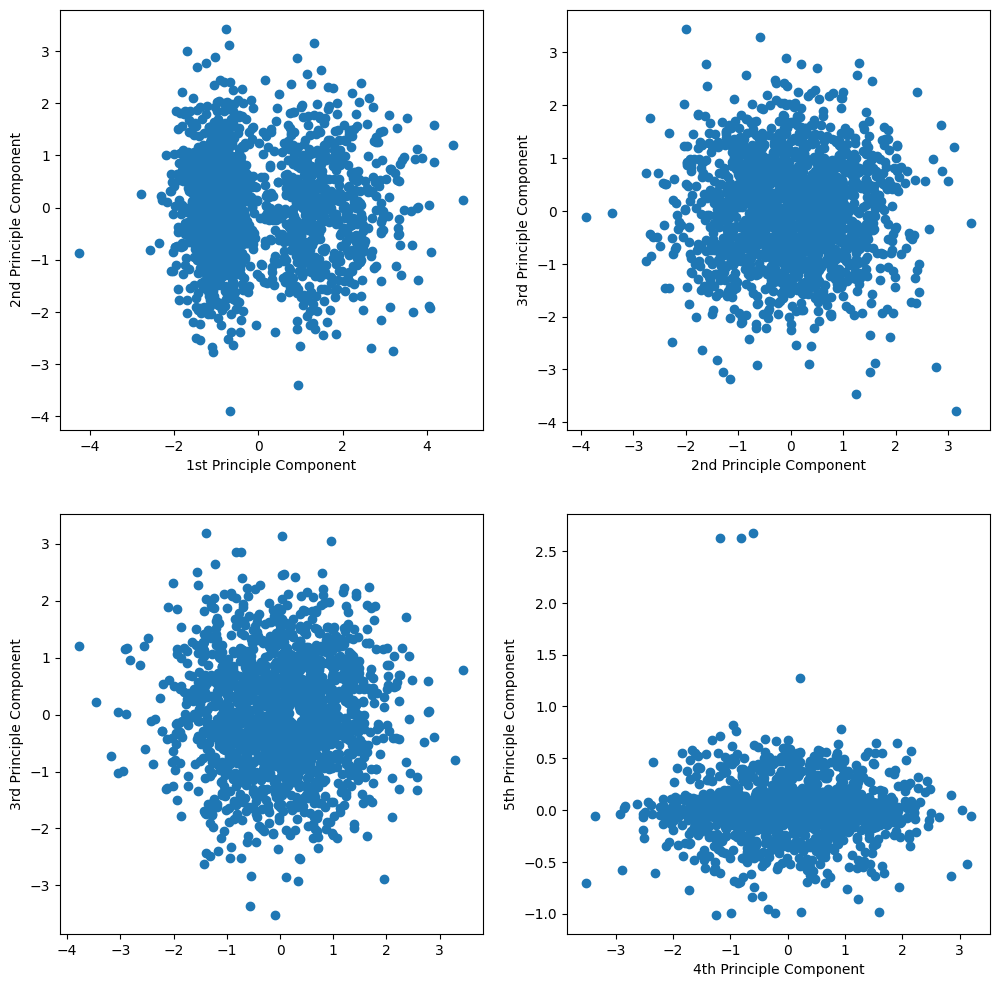

In [48]:
# Plot PCs of data to guess visually K for K-means clustering
fig, axs = subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(scores[:, 0], scores[:, 1])
axs[0, 0].set_ylabel("2nd Principle Component")
axs[0, 0].set_xlabel("1st Principle Component")

axs[0, 1].scatter(scores[:, 1], scores[:, 2])
axs[0, 1].set_ylabel("3rd Principle Component")
axs[0, 1].set_xlabel("2nd Principle Component")

axs[1, 0].scatter(scores[:, 2], scores[:, 3])
axs[1, 0].set_ylabel("4th Principle Component")
axs[1, 0].set_ylabel("3rd Principle Component")

axs[1, 1].scatter(scores[:, 3], scores[:, 4])
axs[1, 1].set_ylabel("5th Principle Component")
axs[1, 1].set_xlabel("4th Principle Component")
#fig.savefig('figure/PC_scatter.pdf')
plt.show()

We can see that the 1st principal component explains around $40\%$ of the variance of the data and if we choose 3 PCs we get above $80\%$ of the variance of the data.

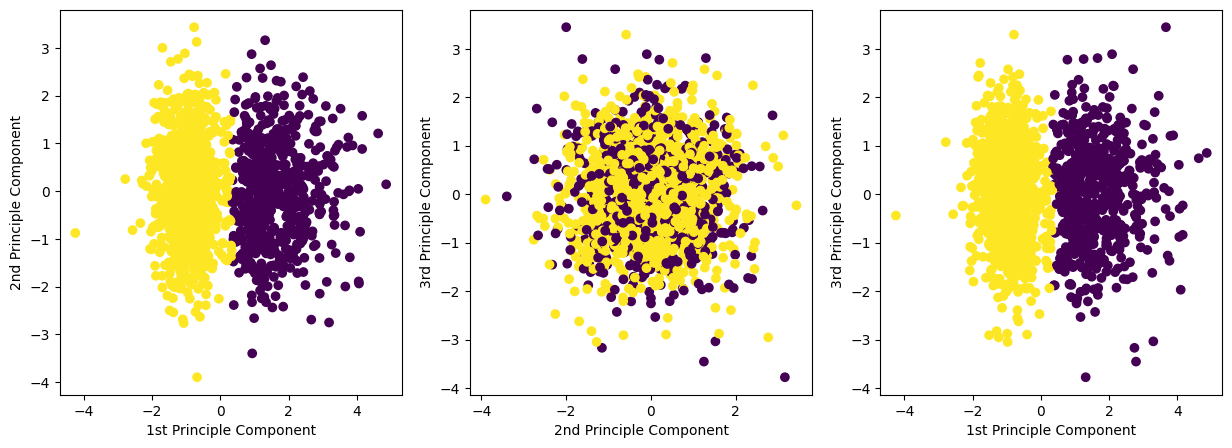

In [49]:
# Apply K-means clustering for K=2
kmeans = KMeans(n_clusters=2,
                random_state=0,
               n_init=50).fit_predict(scores[:,:2])

# Check seperability of clusters
fig, axs = subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].scatter(scores[:, 0], scores[:, 1], c=kmeans)
axs[0].set_xlabel("1st Principle Component")
axs[0].set_ylabel("2nd Principle Component")

axs[1].scatter(scores[:, 1], scores[:, 2], c=kmeans)
axs[1].set_xlabel("2nd Principle Component")
axs[1].set_ylabel("3rd Principle Component")

axs[2].scatter(scores[:, 0], scores[:, 2], c=kmeans)
axs[2].set_xlabel("1st Principle Component")
axs[2].set_ylabel("3rd Principle Component")
fig.savefig('figure/kmean.pdf')
plt.show()

Here we can see that there is good seperation between the 1st PC with the 2nd and 3rd PC, this is due to that the 1st PC explains $\approx 40\%$ of the variance. The seperation between the 2nd and 3rd PC is very poor. We could choose the first 2 PCs since they capture $60\%$ of the data.
______________________________________________________________________________________________________________________________________________________________________________________________________________________

**Part 2: Prediction/inference**

For this section, we provide a data set containing the levels of 100 proteins measured in the plasma of 384 individuals, given on a relative scale (NPX) provided by the manufacturer of the measurement platform. The protein measurements are given in the file MAS202M_2025_proteomics_measurements_20250313.csv. Furthermore, there is information about the age group (1=20-34, 2=36-49, 3=50-64, 5=80+), BMI group (0=<18.5, 1=18.5-24.9, 2=25.0-29.9, 3=30.0-39.9, 4=>40, 5=unknown) and if the individual had COVID or not at the time of measurement. This information is given in the file MAS202M_2025_clinical_info_20250313.csv.

The data set is derived from the MGH-COVID 19 study, provided as supplementary materials with the paper by Filbin and co-workers (2021)1 and accessible in its raw form at https://info.olink.com/broad-covid-study-overview-download

1. Pick a quantitative variable in the data set. Build a regressor for the variable using two different methods. Build a prediction model for the variable using two different methods. At least one of the prediction models should be able to handle non-linear relationships between dimensions. Tune the parameters of each ression model and compare their performances. Discuss the outcome, including the strengths and weaknesses of each type of classifier relative to the data set in question. What (if anything) can you infer about the structure of the data from the models?
   
2. Pick a categorical variable in the data set (or create one by thresholding a continuous variable). Build a classifier for the variable using two different methods. At least one of the classifiers should be able to fit non-linear decision boundaries. Tune the parameters of each classifier and compare their performances. Discuss the outcome, including the strengths and weaknesses of each type of classifier relative to the data set in question. What (if anything) can you infer about the structure of the data from the models?

In [50]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots, cm
import statsmodels.api as sm
import sklearn.linear_model as skl
from scipy.stats import (ttest_1samp,
                         ttest_rel,
                         ttest_ind,
                         t as t_dbn)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests as mult_test
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP import load_data, confusion_table
from ISLP.models import (summarize, 
                        poly,
                        Stepwise,
                        sklearn_selected,
                        ModelSpec as MS)
import seaborn as sns
from functools import partial
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss,
                             RocCurveDisplay)
from sklearn.ensemble import \
                             (RandomForestRegressor as RF,
                             GradientBoostingRegressor as GBR)
from ISLP.bart import BART
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import \
                             (KMeans,
                             AgglomerativeClustering)
from scipy.cluster.hierarchy import \
                             (dendrogram,
                             cut_tree)
from ISLP.cluster import compute_linkage
import warnings; warnings.simplefilter('ignore')
import os
import sys
np.random.seed(0)

In [51]:
# Read csv file into dataframes
df1 = pd.read_csv('MAS202M_2025_proteomics_measurements_20250313.csv')
df2 = pd.read_csv('MAS202M_2025_clinical_info_20250313.csv')
df1.head()

,subject_id,OlinkID,Assay,NPX
0,1,OID20105,ACE2,-1.4261
1,1,OID21188,ADCYAP1R1,-0.0665
2,1,OID21243,AGR3,-1.8488
3,1,OID20658,AGRP,-1.1949
4,1,OID21244,AKR1B1,-1.4979


In [52]:
# Check if there is one-to-one correspondance between columns OlinkID and Assay
df1.shape[0] - np.sum(df1.duplicated(subset=['OlinkID','Assay']))

99

In [53]:
# Set key index in DataFrame and show first 5 rows
df2 = df2.set_index('subject_id')
df2.head()

,COVID,Age_cat,BMI_cat
subject_id,,,
1,1,1,4
2,1,2,2
3,1,3,4
4,1,1,2
5,1,3,3


In [54]:
# Print shape of both dataframes
print(df1.shape)
print(df2.shape)

(37917, 4)
(384, 3)


In [55]:
# Verify how many subjects are in the dataset
df1.shape[0] - np.sum(df1.duplicated(subset=['subject_id']))

383

In [56]:
# Change from long format to wide format
df1_piv = df1.pivot(index='subject_id', columns='Assay', values='NPX')
df3 = df2.join(df1_piv, how='outer')
df3.shape

(384, 102)

In [57]:
# Check if missing values is consistent with our join method
name1 = df1_piv.columns
name2 = df3.columns
s1 = []
s2 = []
for x in name1:
    s1.append(np.sum(pd.isna(df1_piv[x])))

for x in name2:
    s2.append(np.sum(pd.isna(df3[x])))
print(s1)
print(s2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [58]:
# Fill missing values with median of each column
df3_new = df3.fillna(df3.median(numeric_only=True))
df3_new.head()

,COVID,Age_cat,BMI_cat,ACE2,ADCYAP1R1,AGR3,AGRP,AKR1B1,APRT,ARG1,...,TANK,TFF2,TGFB1,TNFRSF8,TP53INP1,TPP1,TPT1,VASH1,WARS,WFDC2
subject_id,,,,,,,,,,,,,,,,,,,,,
1,1,1,4,-1.4261,-0.0665,-1.8488,-1.1949,-1.4979,2.6879,-0.5573,...,0.9909,-2.9175,-2.1341,-2.6635,0.2731,-1.3129,-0.0289,0.4304,-2.1895,-2.1979
2,1,2,2,-2.0836,0.1118,-0.7703,-0.8051,0.8128,3.8750,0.1441,...,2.0778,-3.3033,-0.9424,-1.4371,0.2676,-0.7090,0.2012,0.9346,-0.6989,-2.2326
3,1,3,4,-0.3594,-0.1814,-0.7075,1.8155,0.3256,2.3342,0.0312,...,1.5414,-1.5686,-1.0936,-0.4191,0.3319,-0.5204,0.4359,0.2813,0.2261,-0.4305
4,1,1,2,-2.4722,-0.3032,0.0845,-1.0932,-0.7050,3.1841,1.6858,...,-0.3376,-3.0576,-2.6722,-2.1154,0.2616,-0.8771,0.2771,0.0313,-1.2047,-2.8599
5,1,3,3,-1.6993,0.0913,-0.0364,-0.6008,-0.4118,2.7066,1.5528,...,0.1563,-2.5144,-1.8380,-1.8168,0.4249,0.3213,0.3663,0.2297,-0.6754,-2.5818


We pick the Assay ACE2 for the quantitative variable and use the other protein measurements to predict that value.

In [76]:
# Extract the feature names
feature_names = df3_new.drop(['ACE2'],axis=1).columns

# Create the response variable and the feature matrix
y = df3_new['ACE2']
X = MS(feature_names).fit_transform(df3_new.drop(['ACE2'],axis=1))

# Apply train test split on the dataset
X_train,X_test,y_train,y_test = skm.train_test_split(X,y,test_size=0.33)
design = MS(X_train.columns).fit(X_train)
X = design.transform(X_train)

Use feature Selection and maximize the negative MSE.

In [60]:
# Ridge regression model for forward feature selection
model = skl.ElasticNet(alpha=100,l1_ratio=0,random_state=0)

# Apply forward feature selection
sfs = SequentialFeatureSelector(model,scoring='neg_mean_squared_error').fit(X_train,y_train)

In [77]:
# Create new training and test datasets with the most viable features from forward feature selection
feature = sfs.get_feature_names_out()
name = []
for i in feature:
    name.append(i)
X_train_new = MS(name,intercept=False).fit_transform(X_train)
X_test_new = MS(name,intercept=False).fit_transform(X_test)
X_train_new.shape

(257, 51)

In [78]:
# lambda parameters for ridge regression
alpha = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]

# 5-fold CV
kfold = skm.KFold(5,
                 random_state=0,
                 shuffle=True)

# Ridge regression model used for parameter grid search
ridgeCV = skl.ElasticNet(alpha=100,
                           l1_ratio=0,
                          random_state=0)

# Grid search alpha values
grid = skm.GridSearchCV(ridgeCV,
                       {'alpha': alpha},
                       cv=kfold,
                       scoring='neg_mean_squared_error')
grid.fit(X_train_new,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=ElasticNet(alpha=100, l1_ratio=0, random_state=0),
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                   0.1, 0.5, 1, 5, 10, 50, 100]},
             scoring='neg_mean_squared_error')

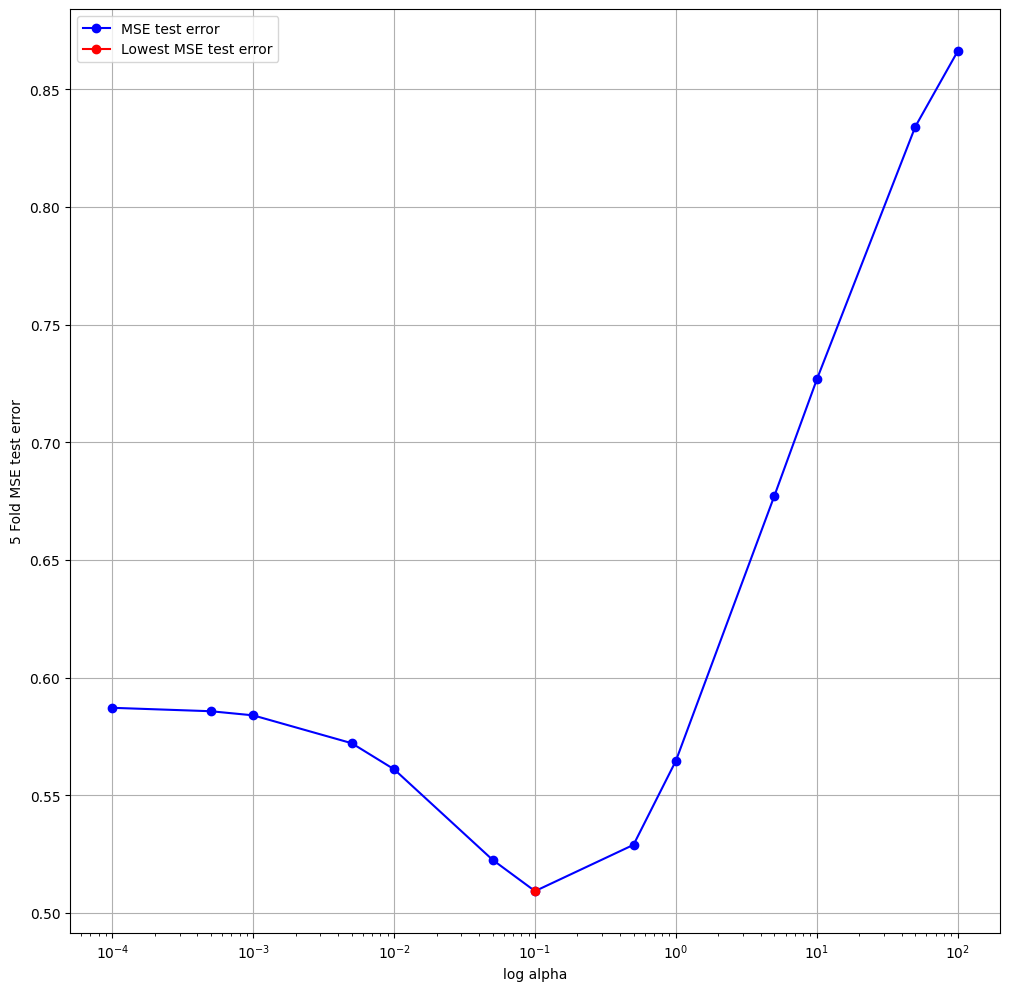

In [79]:
# Plot MSE test error against the log scale of tuning parameters
MSE_test = -grid.cv_results_['mean_test_score']

fig, ax = subplots(figsize=(12,12))
ax.semilogx(alpha,MSE_test,marker='o',color='b')
ax.semilogx(alpha[np.argmin(MSE_test)],np.min(MSE_test),marker='o',color='r')
ax.set_xlabel('log alpha')
ax.set_ylabel('5 Fold MSE test error')
ax.legend(['MSE test error','Lowest MSE test error'])
ax.grid()
fig.savefig('figure/ridgeMSEtest.pdf')
plt.show()

In [80]:
# predict the test dataset
ridge = skl.ElasticNet(alpha=alpha[np.argmin(MSE_test)],l1_ratio=0,random_state=0).fit(X_train_new,y_train)
y_pred = ridge.predict(X_test_new)
print('MSE_error {:.3f}'.format(np.mean((y_test - y_pred)**2)))

MSE_error 0.357


Next we will use a non-linear model that is we'll use Random Forest to predict our test data. We will use feature importance and select the first 30 variables for feature selection.

In [66]:
# trees maximum depth values
max_dep = [1,5,10,50,100,500,1000,5000]

# values for number of trees in the forest
n_est = [10,50,100,500,1000,5000]

# Random Forest regression model
rand_for = RF(max_features='sqrt',
             random_state=0,
              n_estimators=50000,
              max_depth=10)

# 5-fold CV
kfold = skm.KFold(5,
                 random_state=0,
                 shuffle=True)

# Grid searching the variables max_dep and n_est
grid = skm.GridSearchCV(rand_for,
                       {'n_estimators': n_est,
                       'max_depth': max_dep},
                       cv=kfold,
                       scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestRegressor(max_depth=10, max_features='sqrt',
                                             n_estimators=50000,
                                             random_state=0),
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000, 5000],
                         'n_estimators': [10, 50, 100, 500, 1000, 5000]},
             scoring='neg_mean_squared_error')

In [67]:
# Get best estimators
grid.best_params_

{'max_depth': 10, 'n_estimators': 5000}

In [68]:
# Fit RF regression model for all features 
rand = RF(max_depth=10,
         max_features='sqrt',
         n_estimators=5000,
         random_state=0).fit(X_train,y_train)
y_pred = rand.predict(X_test)
print('MSE error for all features {:.3f}'.format(np.sum((y_test - y_pred)**2)))

MSE error for all features 70.883


In [69]:
# Using feature importance for feature selection
feature_imp = pd.DataFrame(
    {'importance': rand.feature_importances_},
    index=X_train.columns
)

# Use the first 30 most important features
X_train_new = MS(feature_imp.sort_values(by='importance',ascending=False).index[:30],intercept=False).fit_transform(X_train)
X_test_new = MS(feature_imp.sort_values(by='importance',ascending=False).index[:30],intercept=False).fit_transform(X_test)
X_train_new.shape

(257, 30)

In [70]:
# Apply grid search for most important features
grid.fit(X_train_new,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestRegressor(max_depth=10, max_features='sqrt',
                                             n_estimators=50000,
                                             random_state=0),
             param_grid={'max_depth': [1, 5, 10, 50, 100, 500, 1000, 5000],
                         'n_estimators': [10, 50, 100, 500, 1000, 5000]},
             scoring='neg_mean_squared_error')

In [71]:
# Get params after searching with the first 30 features 
# with the most importance
grid.best_params_

{'max_depth': 50, 'n_estimators': 1000}

In [74]:
# Fit RF regression model for all features 
rand_f30 = RF(max_depth=50,
         max_features='sqrt',
         n_estimators=1000,
         random_state=0).fit(X_train_new,y_train)
y_pred = rand_f30.predict(X_test_new)
print('MSE error {:.3f}'.format(np.mean((y_test - y_pred)**2)))

MSE error 0.511


In [73]:
# Using feature importance for feature selection
feature_imp = pd.DataFrame(
    {'importance': rand_f30.feature_importances_},
    index=X_train_new.columns
)
feature_imp.sort_values(by='importance',ascending=False)

,importance
SULT2A1,0.088177
CXADR,0.086651
DAG1,0.051384
ITGA5,0.045094
FCAR,0.044587
B4GALT1,0.042380
BCAM,0.040725
SLC16A1,0.032433
MEGF9,0.032258
PDCD1,0.030141


We perform a little bit better than using all of the features, ridge regression performs better on the test prediction.

But both methods give us very similar results, which might suggest that our data has a relatively straightforward relationship that both methods are able to capture effectively.

_________________________________________________________________________________

Now we turn to Classification and use the Covid variable as our categorical variable

In [50]:
# Create datasets and picking a response variable for training
y = df3_new['COVID']
X = df3_new.drop(['COVID'],axis=1)

In [51]:
# Splitting dataset into training and test datasets
X_train,X_test,y_train,y_test = skm.train_test_split(X,y,test_size=0.33)

In [52]:
# Constraint on the slack variables for SVM
C_var = [0.001,0.01,0.1,1,10]

# Linear SVM
svc = SVC(kernel='linear',C=10,random_state=0)

# Forward feature selection
sfs = SequentialFeatureSelector(svc,scoring='accuracy')
sfs.fit(X_train,y_train)

SequentialFeatureSelector(estimator=SVC(C=10, kernel='linear', random_state=0),
                          scoring='accuracy')

In [53]:
# Get feature selected from forward selection and create new datasets for those features
feature = sfs.get_feature_names_out()
name = []
for i in feature:
    name.append(i)
X_train_new = MS(name,intercept=False).fit_transform(X_train)
X_test_new = MS(name,intercept=False).fit_transform(X_test)
X_train_new.shape

(257, 50)

In [54]:
# 5-fold CV
kfold = skm.KFold(5,
                 random_state=0,
                 shuffle=True)

# Grid search C values
grid = skm.GridSearchCV(svc,
                       {'C': C_var},
                       cv=kfold,
                       scoring='accuracy')
grid.fit(X_train_new,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(C=10, kernel='linear', random_state=0),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, scoring='accuracy')

In [55]:
# Get best tuning parameter value from grid searching
grid.best_estimator_

SVC(C=0.1, kernel='linear', random_state=0)

In [56]:
# Create a new classification model using the best tuning parameter
svc_new = SVC(kernel='linear',C=0.1,random_state=0)
svc_new.fit(X_train_new,y_train)

SVC(C=0.1, kernel='linear', random_state=0)

In [57]:
# Predict test dataset and get accuracy of classification
X_test_new = sfs.transform(X_test)
y_pred = svc_new.predict(X_test_new)
print('Accuracy Score {:.3f}%'.format(accuracy_score(y_test,y_pred)*100))

Accuracy Score 85.039%


In [58]:
# Print confusion table
confusion_table(y_pred,y_test)

Truth,0,1
Predicted,,
0,18,5
1,14,90


Now we'll use a method for non-linear classification. For our non-linear classifier we'll use Support vector machine again but use a non-linear kernel, radial basis function.

In [59]:
# Using non linear kernel and apply forward feature selection
svc_rad = SVC(kernel='rbf',
              C=10,
              gamma=1.0,
              random_state=0)
sfs = SequentialFeatureSelector(svc_rad,scoring='accuracy')
sfs.fit(X_train,y_train)

SequentialFeatureSelector(estimator=SVC(C=10, gamma=1.0, random_state=0),
                          scoring='accuracy')

In [60]:
# Get feature selected from forward selection
feature = sfs.get_feature_names_out()
name = []
for i in feature:
    name.append(i)
X_train_new = MS(name,intercept=False).fit_transform(X_train)
X_test_new = MS(name,intercept=False).fit_transform(X_test)
X_train_new.shape

(257, 50)

In [61]:
# Grid search values for C and gamma tuning parameters
C_var = [0.0001,0.001,0.01,0.1,1,10,100,1000]
gam_var = C_var

# 5-fold CV
kfold = skm.KFold(5,
                 random_state=0,
                 shuffle=True)

# Grid searching through tuning parameters C and gamma
grid = skm.GridSearchCV(svc_rad,
                       {'C': C_var,
                       'gamma': gam_var},
                       cv=kfold,
                       scoring='accuracy')
grid.fit(X_train_new,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(C=10, gamma=1.0, random_state=0),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='accuracy')

In [62]:
# Get best estimators
grid.best_params_

{'C': 10, 'gamma': 0.01}

In [63]:
# Apply best tuning parameters predict and get accuracy score
svc_rad_best = SVC(kernel='rbf',C=10,gamma=0.01,random_state=0)
svc_rad_best.fit(X_train_new,y_train)
y_pred = svc_rad_best.predict(X_test_new)
print('Accuracy score {:.3f}%'.format(accuracy_score(y_test,y_pred)*100))

Accuracy score 90.551%


In [64]:
# Print confusion table
confusion_table(y_test,y_pred)

Truth,0,1
Predicted,,
0,23,9
1,3,92


We are able to achieve better classification result on the testing data using a non-linear kernel than we did with a linear one. That may suggest that the decision boundary may be more complex and we may benefit from the higher dimensionality of an rbf kernel. And we need less regularization on the margin, $C=10$, for the non-linear kernel, we need more regularization for linear kernel $C=0.1$. We can interpret this result as the data having some non-linearity such that the rbf kernel was able to better capture with lower regularization.